In [5]:
import sqlite3
import pandas as pd
from datetime import datetime


db_path = 'mmdt.db3'

query = "SELECT ID, Rate FROM attendance;"
df_attend = pd.read_sql_query(query, f"sqlite:///{db_path}")
df_attend['ID'] = df_attend['ID'].str.lower()


In [6]:
current_year = datetime.now().year
query = """
        SELECT p.ID, COALESCE(p.BOD, substr(b.BOD,7,4)) as age, 
        COALESCE(p.Gender, b.Gender) as gender, s.status as status,
        COALESCE(p.Country, b.Country) as country, 
        COALESCE(p.State_Region, b.State_Region) as region
        FROM participants as p
        LEFT JOIN bhutan as b
        on p.ID = b.ID
        LEFT JOIN status as s
        on p.ID = s.PARTICIPANT_ID;
"""
df = pd.read_sql_query(query, f"sqlite:///{db_path}")
cities = ['Yangon', 'Mandalay', 'Nay Pyi Taw', 'Thimphu']
df['region'] = df['region'].map(lambda region: 'urban' if region in cities else 'rural')
df['status'] = df['status'].map(lambda status: 'Complete' if status =='In progress' else status)
df['age'] = df['age'].astype(int)
df.loc[df['age'] >current_year, 'age'] = 2083
df['age'] =  current_year - df['age']


In [7]:
df_clean = df.merge(df_attend, on = 'ID', how = 'left')
df_clean['Rate'] = df_clean['Rate'].fillna('0%')


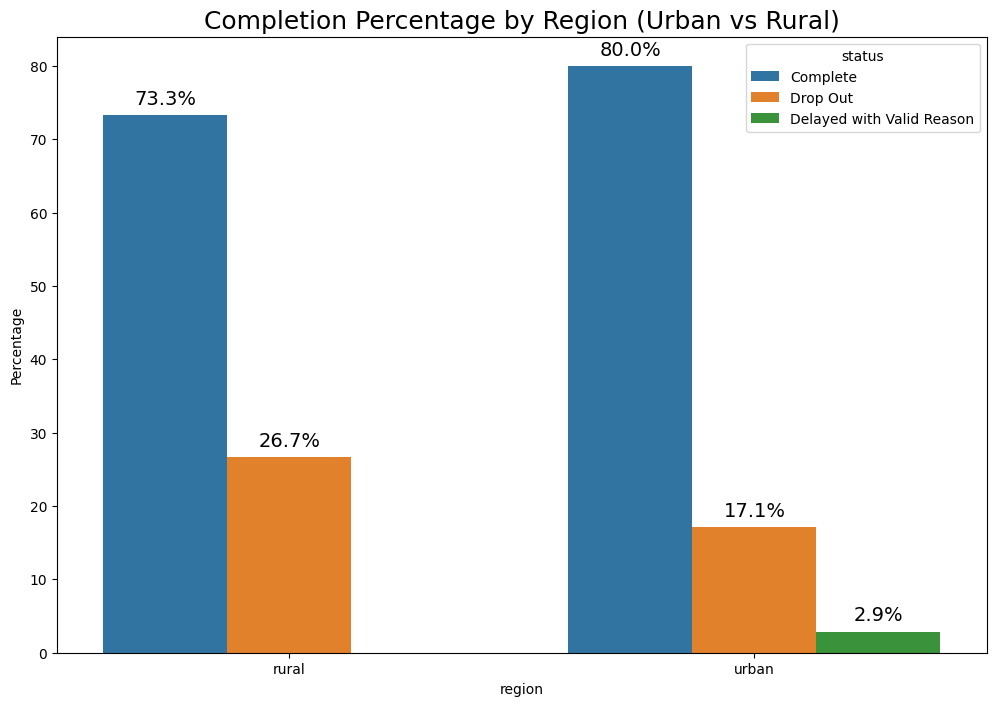

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
count_data = df_clean.groupby(['region', 'status']).size().reset_index(name='count')
count_data['percentage'] = count_data.groupby('region')['count'].transform(lambda x: (x / x.sum()) * 100)
count_data['percentage'] = count_data['percentage'].round(2)

# Create the count plot using percentage
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='region', y='percentage', hue='status', data=count_data)
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v:.1f}%' for v in container.datavalues], 
                 fontsize=14, color='black', padding=5)
# Set plot labels and title
plt.ylabel('Percentage')
plt.title('Completion Percentage by Region (Urban vs Rural)', fontdict={'size':18})

# Show the plot
plt.show()

Text(0, 0.5, 'Number of Participants')

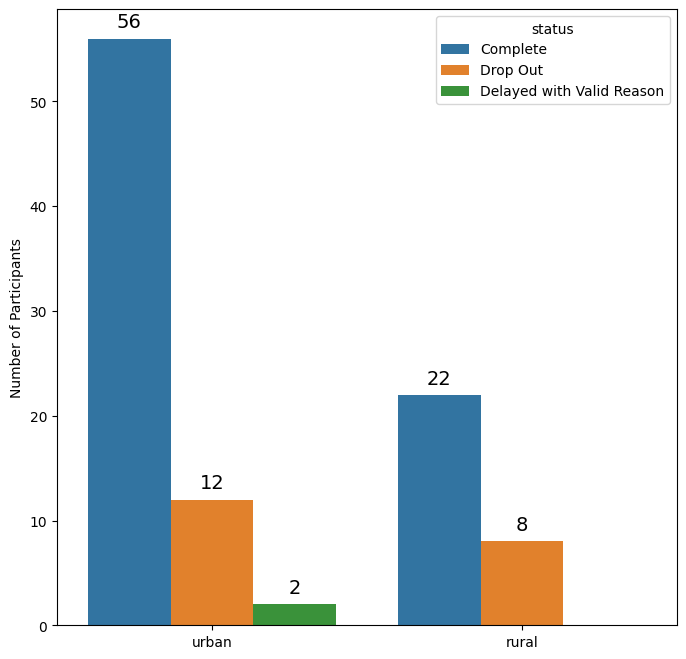

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 8))
ax=sns.countplot(x='region', hue='status', data=df_clean)
for container in ax.containers:
    ax.bar_label(container, labels=[int(v) for v in container.datavalues], 
                 fontsize=14, color='black', padding=5)

plt.title('')
plt.xlabel('')
plt.ylabel('Number of Participants')

In [15]:
pivot_table = pd.crosstab(df['region'], df['status'])
crosstab_df = pivot_table.reset_index().melt(id_vars=['region'], var_name='status', value_name='Count')
crosstab_df

import plotly.express as px
plt.figure(figsize=(8, 6))
fig = px.treemap(crosstab_df, 
                 path=['status', 'region'],  # Hierarchical structure
                 values='Count',               # Size based on this column
                 color='region',                # Color based on the value
                 hover_data=['status', 'region'])  # Show these details on hover

fig.update_layout(title="Completion of participants from Urban and Rural Area")
fig.update_traces(textinfo='label+value', textfont=dict(size=18))
fig.show()

<Figure size 800x600 with 0 Axes>